# AORC HMS Execution and Results

This notebook demonstrates how to execute HEC-HMS simulations using AORC gridded precipitation and analyze the results.

**Workflow Overview**:
1. Initialize HMS project with AORC grids
2. Execute HMS simulation
3. Extract peak flows and time series
4. Visualize results

**Prerequisites**:
- Complete **14a_aorc_download.ipynb** and **14b_aorc_grid_setup.ipynb** first
- HEC-HMS 4.x installation with example projects

**Series Navigation**:
- **14a**: AORC download and storm catalog
- **14b**: HMS grid definition and HRAP mapping
- **14c** (this notebook): HMS execution and results analysis

In [1]:
# pip install hms-commander[all]

**For Development**: If working on hms-commander source code, use the `hmscmdr_local` conda environment (editable install) instead of pip install.

## Setup and Imports

In [2]:
from pathlib import Path
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

# HMS Commander imports
from hms_commander import (
    init_hms_project, HmsCmdr, HmsResults, HmsBasin, 
    HmsExamples, hms
)

print(f"Workflow started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Workflow started: 2026-01-08 13:34:26


## Extract Example Project

The `tenk` example project is the only HMS example with gridded precipitation support. We'll use it as a template for demonstration.

In [3]:
# Extract the tenk example project (required for HMS operations)
print("Extracting tenk example project...")
try:
    tenk_path = HmsExamples.extract_project("tenk")
    print(f"  Extracted to: {tenk_path}")
    TENK_AVAILABLE = True
except Exception as e:
    print(f"  Warning: Could not extract tenk project: {e}")
    print("  Please ensure HEC-HMS is installed with example projects.")
    TENK_AVAILABLE = False
    tenk_path = None

2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Found HMS 4.10 at C:\Program Files\HEC\HEC-HMS\4.10


2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Found HMS 4.11 at C:\Program Files\HEC\HEC-HMS\4.11


2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Found HMS 4.12 at C:\Program Files\HEC\HEC-HMS\4.12


2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Found HMS 4.13 at C:\Program Files\HEC\HEC-HMS\4.13


2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Found HMS 4.4.1 at C:\Program Files\HEC\HEC-HMS\4.4.1


2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Found HMS 4.5 at C:\Program Files\HEC\HEC-HMS\4.5


2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Found HMS 4.6 at C:\Program Files\HEC\HEC-HMS\4.6


2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Found HMS 4.7.1 at C:\Program Files\HEC\HEC-HMS\4.7.1


2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Found HMS 4.8 at C:\Program Files\HEC\HEC-HMS\4.8


2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Found HMS 4.9 at C:\Program Files\HEC\HEC-HMS\4.9


2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Found HMS 3.0.0 at C:\Program Files (x86)\HEC\HEC-HMS\3.0.0


2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Found HMS 3.0.1 at C:\Program Files (x86)\HEC\HEC-HMS\3.0.1


2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Found HMS 3.1.0 at C:\Program Files (x86)\HEC\HEC-HMS\3.1.0


2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Found HMS 3.2 at C:\Program Files (x86)\HEC\HEC-HMS\3.2


2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Found HMS 3.3 at C:\Program Files (x86)\HEC\HEC-HMS\3.3


2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Found HMS 3.4 at C:\Program Files (x86)\HEC\HEC-HMS\3.4


2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Found HMS 3.5 at C:\Program Files (x86)\HEC\HEC-HMS\3.5


2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Found HMS 4.0 at C:\Program Files (x86)\HEC\HEC-HMS\4.0


2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Found HMS 4.1 at C:\Program Files (x86)\HEC\HEC-HMS\4.1


2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Found HMS 4.2.1 at C:\Program Files (x86)\HEC\HEC-HMS\4.2.1


2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Found HMS 4.3 at C:\Program Files (x86)\HEC\HEC-HMS\4.3


2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Found 21 HMS installation(s) with examples


2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Catalog built: 68 project entries


2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Using latest installed version: 4.13


2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Removing existing project folder: C:\GH\hms-commander\examples\hms_example_projects\tenk


2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Extracting 'tenk' from HMS 4.13


2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Source: C:\Program Files\HEC\HEC-HMS\4.13\samples.zip


2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Destination: C:\GH\hms-commander\examples\hms_example_projects\tenk


2026-01-08 13:34:26 - hms_commander.HmsExamples - INFO - Successfully extracted 'tenk' to C:\GH\hms-commander\examples\hms_example_projects\tenk


Extracting tenk example project...
  Extracted to: C:\GH\hms-commander\examples\hms_example_projects\tenk


---

## Initialize HMS Project

In [4]:
if TENK_AVAILABLE:
    # Initialize the HMS project
    project_dir = tenk_path
    hms_project = init_hms_project(project_dir)

    print("HMS Project Initialized:")
    print(f"  Project: {hms_project.project_name}")
    print(f"  Directory: {hms_project.project_folder}")

    # Show available runs
    print(f"\nAvailable Runs ({len(hms_project.run_df)}):")
    for _, row in hms_project.run_df.iterrows():
        print(f"  - {row['name']}")
else:
    print("Skipping: tenk project not available")

2026-01-08 13:34:26 - hms_commander.HmsPrj - INFO - HMS project initialized: tenk


2026-01-08 13:34:26 - hms_commander.HmsPrj - INFO -   Version: 4.13


2026-01-08 13:34:26 - hms_commander.HmsPrj - INFO -   Basin models: 1


2026-01-08 13:34:26 - hms_commander.HmsPrj - INFO -   Met models: 1


2026-01-08 13:34:26 - hms_commander.HmsPrj - INFO -   Control specs: 1


2026-01-08 13:34:26 - hms_commander.HmsPrj - INFO -   Simulation runs: 1


2026-01-08 13:34:26 - hms_commander.HmsPrj - INFO -   Gages: 4


2026-01-08 13:34:26 - hms_commander.HmsPrj - INFO -   Paired data tables: 4


HMS Project Initialized:
  Project: tenk
  Directory: C:\GH\hms-commander\examples\hms_example_projects\tenk

Available Runs (1):
  - Jan 96 storm


In [5]:
if TENK_AVAILABLE:
    # Show basin model subbasins
    print("Basin Model Subbasins:")
    print(hms_project.subbasin_df[['name', 'area', 'downstream']].head(10))
else:
    print("Skipping: tenk project not available")

Basin Model Subbasins:
  name   area downstream
0   86  635.0      Watts
1   85  324.0  Tahlequah
2  113  307.0      Eldon
3  127  345.0  Tenkiller


---

## HMS Basin Model Geometry

Visualize the HMS basin model structure showing subbasins, junctions, and reaches.

2026-01-08 13:34:29 - hms_commander.HmsBasin - INFO - Reading subbasins from: C:\GH\hms-commander\examples\hms_example_projects\tenk\Tenk_1.basin


2026-01-08 13:34:29 - hms_commander.HmsBasin - INFO - Found 4 subbasins


Using basin file: C:\GH\hms-commander\examples\hms_example_projects\tenk\Tenk_1.basin

Basin Model Elements:
  Subbasins: 4
  Junctions: 5
  Reaches:   5


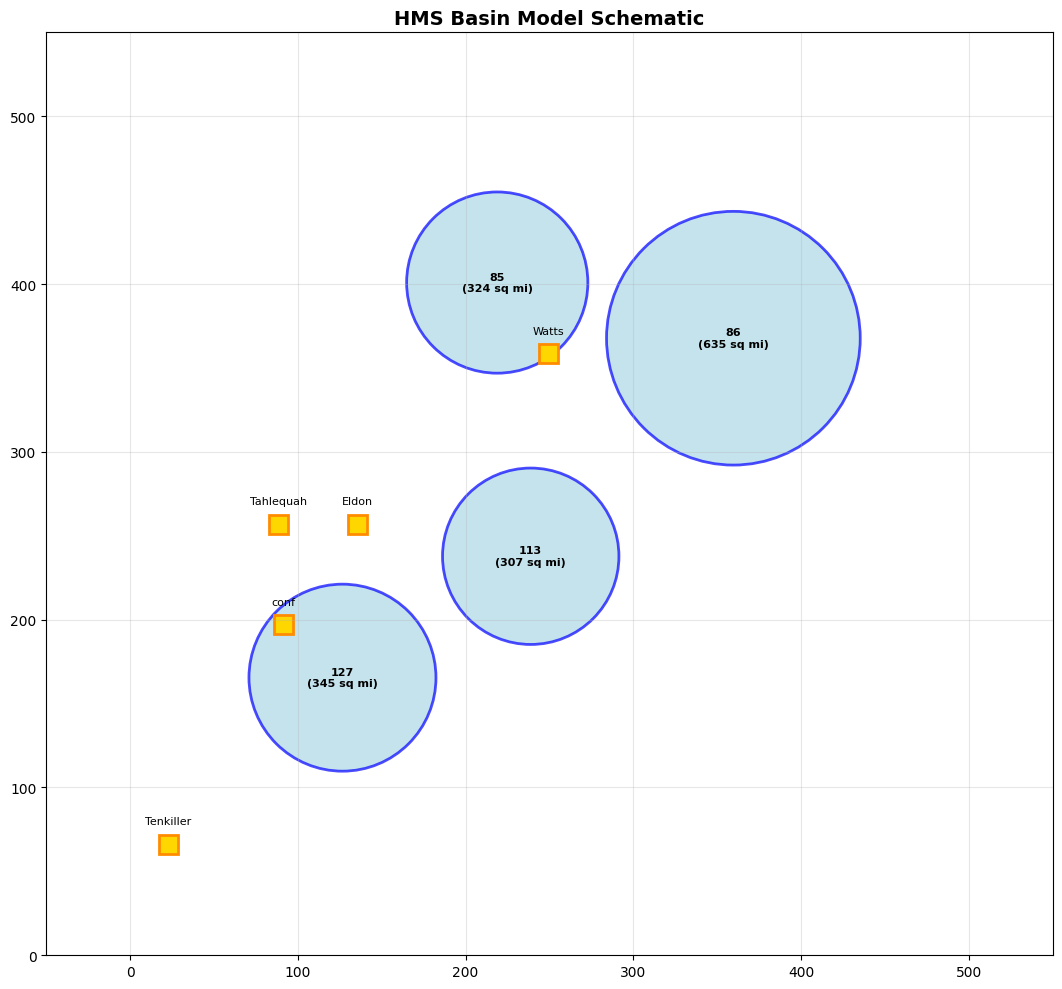

In [6]:
if TENK_AVAILABLE:
    try:
        import matplotlib.pyplot as plt
        import numpy as np

        basin_files = list(tenk_path.glob('*.basin'))
        if basin_files:
            basin_file = str(basin_files[0])
            print(f"Using basin file: {basin_file}")

            subbasins = HmsBasin.get_subbasins(basin_file)
            junctions = HmsBasin.get_junctions(basin_file)
            reaches = HmsBasin.get_reaches(basin_file)

            print(f"\nBasin Model Elements:")
            print(f"  Subbasins: {len(subbasins)}")
            print(f"  Junctions: {len(junctions)}")
            print(f"  Reaches:   {len(reaches)}")

            fig, ax = plt.subplots(figsize=(12, 10))

            # Plot subbasins as circles
            for idx, sub in subbasins.iterrows():
                x, y = float(sub['canvas_x']), float(sub['canvas_y'])
                size = np.sqrt(float(sub['area'])) * 3
                circle = plt.Circle((x, y), size, color='lightblue', ec='blue', linewidth=2, alpha=0.7)
                ax.add_patch(circle)
                ax.annotate(f"{sub['name']}\n({float(sub['area']):.0f} sq mi)",
                            (x, y), ha='center', va='center', fontsize=8, fontweight='bold')

            # Plot junctions as diamonds
            for idx, junc in junctions.iterrows():
                x, y = float(junc['canvas_x']), float(junc['canvas_y'])
                diamond = plt.matplotlib.patches.RegularPolygon(
                    (x, y), numVertices=4, radius=8,
                    orientation=np.pi/4, color='gold', ec='darkorange', linewidth=2
                )
                ax.add_patch(diamond)
                ax.annotate(junc['name'], (x, y+12), ha='center', fontsize=8)

            ax.set_xlim(-50, 550)
            ax.set_ylim(0, 550)
            ax.set_aspect('equal')
            ax.set_title('HMS Basin Model Schematic', fontsize=14, fontweight='bold')
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        else:
            print("No basin files found")

    except ImportError:
        print("Matplotlib not available - skipping visualization")
else:
    print("Skipping: tenk project not available")

---

## Execute HMS Simulation

Run the HMS simulation using the gridded precipitation data.

In [7]:
if TENK_AVAILABLE:
    # Execute HMS - run the first available run
    run_name = hms_project.run_df.iloc[0]['name']
    print(f"Executing HMS run: {run_name}")
    print("=" * 50)

    success = HmsCmdr.compute_run(run_name)

    if success:
        print(f"\nRun completed successfully!")
    else:
        print(f"\nRun failed or completed with warnings")
else:
    print("Skipping: tenk project not available")

2026-01-08 13:34:29 - hms_commander.HmsJython - INFO - Found HEC-HMS: C:\Program Files\HEC\HEC-HMS\4.10


2026-01-08 13:34:29 - hms_commander.HmsCmdr - INFO - Computing run 'Jan 96 storm' in C:\GH\hms-commander\examples\hms_example_projects\tenk


2026-01-08 13:34:29 - hms_commander.HmsJython - INFO - Executing HMS 4.10 via direct Java invocation


2026-01-08 13:34:29 - hms_commander.HmsJython - INFO - Script: C:\GH\hms-commander\examples\hms_example_projects\tenk\hms_script.py


2026-01-08 13:34:29 - hms_commander.HmsJython - INFO - Memory: -Xms128M -Xmx4G


Executing HMS run: Jan 96 storm


2026-01-08 13:34:33 - hms_commander.HmsJython - INFO - HMS 4.10 script executed successfully


2026-01-08 13:34:33 - hms_commander.HmsCmdr - INFO - Run 'Jan 96 storm' completed successfully



Run completed successfully!


---

## Analyze Results - Peak Flows

Extract and display peak flow results from the HMS simulation.

In [8]:
if TENK_AVAILABLE:
    # Find the DSS results file
    dss_results = list(tenk_path.glob("**/*.dss"))
    print(f"Found {len(dss_results)} DSS files:")
    for dss in dss_results:
        print(f"  {dss.name}: {dss.stat().st_size / 1024:.1f} KB")

    # The results DSS is named after the run (with underscores replacing spaces)
    results_dss_list = [d for d in dss_results if "hrap" not in d.name.lower() and "tenk" not in d.name.lower()]
    if results_dss_list:
        results_dss = results_dss_list[0]
        print(f"\nUsing results DSS: {results_dss.name}")
    else:
        results_dss = None
        print("No results DSS file found")
else:
    print("Skipping: tenk project not available")

Found 3 DSS files:
  hrap.dss: 1193.5 KB
  Jan_96_storm.dss: 632.5 KB
  tenk.dss: 26.5 KB

Using results DSS: Jan_96_storm.dss


In [9]:
if TENK_AVAILABLE and results_dss:
    # Extract peak flows from the results DSS file
    print(f"Analyzing results from: {results_dss.name}")

    try:
        # Get DSS catalog to see what's available
        from ras_commander.dss import RasDss
        catalog = RasDss.get_catalog(str(results_dss))
        
        # Filter for FLOW records
        flow_records = [p for p in catalog if 'FLOW' in p.upper()]
        print(f"\nFlow records found: {len(flow_records)}")
        
        # Get peak flows for all elements
        peaks = HmsResults.get_peak_flows(str(results_dss))
        
        if len(peaks) > 0:
            print(f"\nPeak Flow Summary ({len(peaks)} elements):")
            print("=" * 70)
            print(f"{'Element':<30} {'Peak Flow (cfs)':>15} {'Time to Peak':>20}")
            print("-" * 70)
            
            for element, row in peaks.iterrows():
                peak_flow = row.get('Peak Flow (cfs)', row.get('peak_flow', 'N/A'))
                time_peak = row.get('Time to Peak', row.get('time_to_peak', 'N/A'))
                if isinstance(peak_flow, (int, float)):
                    print(f"{element:<30} {peak_flow:>15.1f} {str(time_peak):>20}")
                else:
                    print(f"{element:<30} {str(peak_flow):>15} {str(time_peak):>20}")
        else:
            print("No peak flows extracted")
            
    except Exception as e:
        print(f"Error extracting peak flows: {e}")
else:
    print("Skipping: results not available")

Analyzing results from: Jan_96_storm.dss


Configuring Java VM for DSS operations...
  Found Java: C:\Program Files\Java\jre1.8.0_471
[OK] Java VM configured


2026-01-08 13:34:35 - hms_commander.dss.core - WARNING - JVM already running, cannot set max_memory=4G


2026-01-08 13:34:35 - hms_commander.dss.core - WARNING - JVM already running, cannot set max_memory=4G


2026-01-08 13:34:35 - hms_commander.dss.hms_dss - INFO - Extracting peaks from 14 paths...


2026-01-08 13:34:35 - hms_commander.dss.hms_dss - INFO - Extracting peaks from 14 paths...


2026-01-08 13:34:35 - hms_commander.dss.hms_dss - INFO - Batch 1/1: processing 14 paths...


2026-01-08 13:34:35 - hms_commander.dss.hms_dss - INFO - Batch 1/1: processing 14 paths...



Flow records found: 0


2026-01-08 13:34:35 - hms_commander.dss.hms_dss - INFO - Extracted peak flows for 14 elements


2026-01-08 13:34:35 - hms_commander.dss.hms_dss - INFO - Extracted peak flows for 14 elements



Peak Flow Summary (14 elements):
Element                        Peak Flow (cfs)         Time to Peak
----------------------------------------------------------------------
0                                       7656.1                  N/A
1                                       6846.6                  N/A
2                                       6846.6                  N/A
3                                       6700.5                  N/A
4                                       6700.5                  N/A
5                                       6546.2                  N/A
6                                       6546.2                  N/A
7                                       6202.3                  N/A
8                                       6106.5                  N/A
9                                       5933.6                  N/A
10                                      5837.2                  N/A
11                                      5712.8                  N/A
12         

### Per-Element Peak Flow Analysis

In [10]:
if TENK_AVAILABLE and results_dss:
    try:
        from ras_commander.dss import RasDss

        catalog = RasDss.get_catalog(str(results_dss))
        
        flow_records = [p for p in catalog if '/FLOW/' in p.upper()
                        and 'OBSERVED' not in p.upper()
                        and 'CUMULATIVE' not in p.upper()
                        and 'RESIDUAL' not in p.upper()]

        # Extract peak flows for each element
        element_peaks = {}

        for pathname in flow_records:
            parts = pathname.split('/')
            if len(parts) >= 3:
                element_name = parts[2]

                try:
                    ts = RasDss.read_timeseries(str(results_dss), pathname)
                    if ts is not None and len(ts) > 0:
                        vals = ts.values.flatten() if ts.values.ndim > 1 else ts.values
                        peak_val = float(vals.max())
                        peak_idx = int(vals.argmax())
                        peak_time = ts.index[peak_idx]

                        if element_name not in element_peaks:
                            element_peaks[element_name] = []
                        element_peaks[element_name].append({
                            'pathname': pathname,
                            'peak_flow': peak_val,
                            'peak_time': peak_time,
                            'parameter': parts[3] if len(parts) > 3 else 'FLOW'
                        })
                except Exception:
                    pass

        print(f"Elements with peak flows: {len(element_peaks)}")
        for elem, peaks_list in element_peaks.items():
            max_peak = max(p['peak_flow'] for p in peaks_list)
            print(f"  {elem}: {len(peaks_list)} records, max peak: {max_peak:.0f} cfs")
            
    except Exception as e:
        print(f"Error analyzing elements: {e}")
else:
    print("Skipping: results not available")

Elements with peak flows: 0


### Peak Flow Summary Chart

In [11]:
# Check if element_peaks exists and has data before plotting
if TENK_AVAILABLE and 'element_peaks' in locals() and element_peaks:
    try:
        import matplotlib.pyplot as plt

        # Get max peak for each element
        all_elements = {}
        for elem, peaks_list in element_peaks.items():
            max_peak = max(peaks_list, key=lambda x: x['peak_flow'])
            all_elements[elem] = max_peak['peak_flow']

        sorted_elements = sorted(all_elements.items(), key=lambda x: x[1], reverse=True)
        names = [x[0] for x in sorted_elements]
        values = [x[1] for x in sorted_elements]

        fig, ax = plt.subplots(figsize=(12, 8))
        bars = ax.barh(range(len(names)), values, color='steelblue', alpha=0.8)
        ax.set_yticks(range(len(names)))
        ax.set_yticklabels(names)
        ax.set_xlabel('Peak Flow (cfs)')
        ax.set_title('Peak Flows by Element', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')

        # Add value labels
        for i, (name, val) in enumerate(sorted_elements):
            ax.text(val + max(values)*0.01, i, f'{val:,.0f}', va='center', fontsize=9)

        plt.tight_layout()
        plt.show()

    except ImportError:
        print("Matplotlib not available - skipping visualization")
else:
    print("Skipping: no element peak data available")

Skipping: no element peak data available


### Outlet Hydrograph

In [12]:
if TENK_AVAILABLE and results_dss:
    try:
        import matplotlib.pyplot as plt
        from ras_commander.dss import RasDss
        
        # Get DSS catalog and find FLOW records
        catalog = RasDss.get_catalog(str(results_dss))
        flow_records = [p for p in catalog if 'FLOW' in p.upper() and 'OBSERVED' not in p.upper()]
        
        if flow_records:
            # Use first flow record
            pathname = flow_records[0]
            print(f"Plotting hydrograph for: {pathname}")
            
            ts = RasDss.read_timeseries(str(results_dss), pathname)
            
            if ts is not None and len(ts) > 0:
                fig, ax = plt.subplots(figsize=(12, 6))
                
                vals = ts.values.flatten() if ts.values.ndim > 1 else ts.values
                
                ax.plot(ts.index, vals, 'b-', linewidth=1.5)
                ax.fill_between(ts.index, vals, alpha=0.3)
                ax.set_xlabel('Time')
                ax.set_ylabel('Flow (cfs)')
                
                # Extract element name from pathname
                parts = pathname.split('/')
                element_name = parts[2] if len(parts) >= 3 else 'Outlet'
                
                # Mark peak
                peak_idx = vals.argmax()
                peak_val = vals.max()
                peak_time = ts.index[peak_idx]
                ax.axhline(y=peak_val, color='r', linestyle='--', alpha=0.5)
                ax.scatter([peak_time], [peak_val], color='red', s=100, zorder=5)
                ax.annotate(f'Peak: {peak_val:,.0f} cfs', 
                           xy=(peak_time, peak_val), xytext=(10, 10),
                           textcoords='offset points', fontsize=10,
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                
                ax.set_title(f'{element_name} Hydrograph', fontsize=14, fontweight='bold')
                ax.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
            else:
                print("No data in timeseries")
        else:
            print("No flow records found")

    except ImportError:
        print("Matplotlib not available - skipping visualization")
    except Exception as e:
        print(f"Error plotting hydrograph: {e}")
else:
    print("Skipping: results not available")

No flow records found


---

## Complete Workflow Summary

All phases of the AORC gridded precipitation workflow have been completed.

In [13]:
print("=" * 70)
print("COMPLETE AORC GRIDDED PRECIPITATION WORKFLOW")
print("=" * 70)

print("\n[OK] Phase 1-2 (14a): AORC Download")
print("    HUC watersheds downloaded, storm catalog generated")
print("    AORC data downloaded and converted to DSS")

print("\n[OK] Phase 3 (14b): HMS Grid Configuration")
print("    Grid definition file created")
print("    Grid cell mapping (hrapcells) generated")

if TENK_AVAILABLE:
    print(f"\n[OK] Phase 4 (14c): HMS Execution")
    print(f"    Project: {hms_project.project_name}")
    if 'run_name' in locals():
        print(f"    Run: {run_name}")
    if 'element_peaks' in locals() and element_peaks:
        max_peak = max(max(p['peak_flow'] for p in peaks_list) 
                       for peaks_list in element_peaks.values())
        print(f"    Maximum peak flow: {max_peak:,.0f} cfs")
else:
    print("\n[SKIPPED] Phase 4 (14c): HMS Execution")
    print("    tenk project not available")

print(f"\nWorkflow completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

COMPLETE AORC GRIDDED PRECIPITATION WORKFLOW

[OK] Phase 1-2 (14a): AORC Download
    HUC watersheds downloaded, storm catalog generated
    AORC data downloaded and converted to DSS

[OK] Phase 3 (14b): HMS Grid Configuration
    Grid definition file created
    Grid cell mapping (hrapcells) generated

[OK] Phase 4 (14c): HMS Execution
    Project: tenk
    Run: Jan 96 storm

Workflow completed: 2026-01-08 13:34:35


---

## Next Steps: Using in Your Own HMS Project

To use AORC gridded precipitation in your own HEC-HMS project:

1. **Copy files to HMS project folder**:
   - `aorc_storm.dss` - Grid data
   - `aorc.grid` - Grid definition
   - `hrapcells` - Grid cell mapping

2. **Configure Meteorologic Model**:
   - Create new Met Model with type "Gridded Precipitation"
   - Select the grid definition
   - Associate subbasins with hrapcells regions

3. **Configure Basin Model**:
   - Create subbasins matching your HUC names
   - Set transform method to "ModClark" for distributed routing

4. **Run Simulation**:
   - Create control specification covering storm period
   - Create run combining basin, met, and control
   - Execute and analyze results

---

## Additional Resources

- **HmsHuc API**: `help(HmsHuc)` - HUC watershed operations
- **HmsAorc API**: `help(HmsAorc)` - AORC data operations
- **HmsGrid API**: `help(HmsGrid)` - Grid file operations
- **Example Project**: `tenk` in HMS examples has gridded precipitation
- **AORC Documentation**: https://registry.opendata.aws/noaa-nws-aorc/